In [55]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [56]:
def genreate_stock_data(stock_name,period):
    company = yf.Ticker(stock_name)
    df = company.history(period=period)
    
    #Create the current trend of the current stock
    t = []
    for i in range(len(df)):
        if(df['Open'].iloc[i]-df['Close'].iloc[i]>0):
            t.append("DOWN")
        else:
            t.append("UP")
            
    df['Trend']=t
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the trend history of the stock
    th=[0]
    current_trend = df['Trend'].iloc[0]
    count = 0
    for i in range(1,len(df)):
        if(current_trend==df['Trend'].iloc[i]):
            count+=1
            th.append(count)
        else:
            count = 0
            th.append(count)
            current_trend = df['Trend'].iloc[i]
            
    df["Trend history"]=th
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the comparison to the change since last peak
    p=[]
    v=[]
    if(df['Trend'].iloc[0]=="DOWN"):
        peak = df['Open'].iloc[0]
        valley = df['Close'].iloc[0]
    else:
        valley = df['Open'].iloc[0]
        peak = df['Close'].iloc[0]

    for i in range(0,len(df)):

        p.append(peak-df['Close'].iloc[i])
        v.append(valley-df['Close'].iloc[i])

        if peak<df['Close'].iloc[i]:
            peak = df['Close'].iloc[i]
        if valley>df['Close'].iloc[i]:
            valley = df['Close'].iloc[i]
            
    df['Change since last peak']=p
    df['Change since last drop']=v
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the local change of daily stock
    c=[]
    cm=[]
    for i in range(0,len(df)):
        c.append(df['Open'].iloc[i]-df['Close'].iloc[i])
        cm.append(df['High'].iloc[i]-df['Low'].iloc[i])

    df['Local Change']=c
    df['Local range of stock price']=cm
    #-------------------------------------------------------------------------------------------------------------
    
    #Create dummy variable for the categorical variable
    df = pd.get_dummies(df,drop_first=True)
    #-------------------------------------------------------------------------------------------------------------
    
    #Create the label for the change from tommorow, the data that needs to be predicted
    next_day_change = df['Local Change'][1:]
    #-------------------------------------------------------------------------------------------------------------
    
    #Add the created label to the database
    df = df[1:]
    df["Next day prediction of change"]=next_day_change
    #-------------------------------------------------------------------------------------------------------------
    
    #Sepreate the dates of the stock for further use if required
    date = (df.reset_index())['Date']
    #-------------------------------------------------------------------------------------------------------------
    
    #Remove data object from the database
    df = (df.reset_index()).drop('Date',axis=1)
    #-------------------------------------------------------------------------------------------------------------
    
    #Break the data into features and labels
    X = df.drop(['Next day prediction of change'],axis=1)
    y = df["Next day prediction of change"]
    #-------------------------------------------------------------------------------------------------------------
    
    return(date,X,y)

In [57]:
def poly_convert(X,n):
    polynomial_converter = PolynomialFeatures(degree=n,include_bias=False)
    poly_features = polynomial_converter.fit_transform(X)
    return(poly_features)

In [58]:
def evaluate_stock(stock,duration,iterations):
    
    date, X, y = genreate_stock_data(stock,duration)
    
    train_rmse_errors = []
    test_rmse_errors = []
    for i in range(1,iterations):
        polynomial_converter = PolynomialFeatures(degree=i,include_bias=False)
        poly_features = polynomial_converter.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=101)
        model = create_model(stock,duration,i)
        model.fit(X_train,y_train)

        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        train_RMSE = mean_absolute_percentage_error(y_train,train_pred)
        test_RMSE = mean_absolute_percentage_error(y_test,test_pred)

        train_rmse_errors.append(train_RMSE)
        test_rmse_errors.append(test_RMSE)
        
    plt.plot(range(1,7),train_rmse_errors,label='TRAIN')    
    plt.plot(range(1,7),test_rmse_errors,label='TEST')
    plt.xlabel("Polynomial Complexity")
    plt.ylabel("RMSE")
    plt.legend()

In [59]:
def create_model(stock,duration,n):
    date, X, y = genreate_stock_data(stock,duration)
    
    X = poly_convert(X,n)
    
    model = LinearRegression(fit_intercept=True)
    model.fit(X,y)
    
    return(model)

In [60]:
def model_predict(model,n,X,y):
    X_poly = poly_convert(X,n)
    y_predict = model.predict(X_poly)
    train_RMSE = mean_absolute_percentage_error(y,y_predict)
    
    print(train_RMSE)
    
    if(y.empty):
        plt.plot(X.index,y_predict)
    else:
        plt.plot(X.index,y,y_predict)
        plt.legend(["Actual","Predicted"])

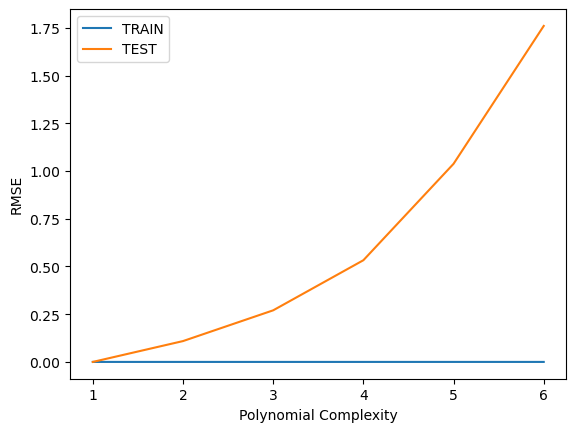

In [61]:
evaluate_stock('MSFT','1mo',7)

7.198445910479059e-11


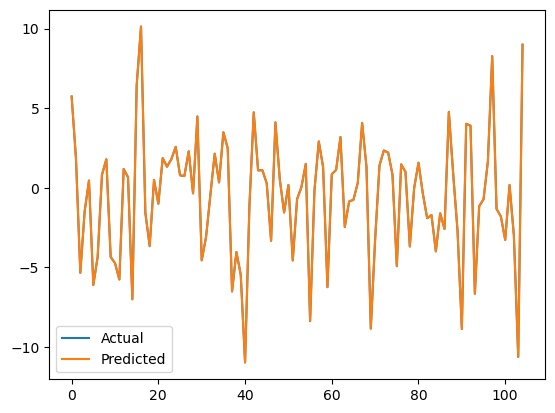

In [62]:
model = create_model('MSFT','2mo',1)
date,X,y= genreate_stock_data('MSFT','5mo')
model_predict(model,1,X,y)

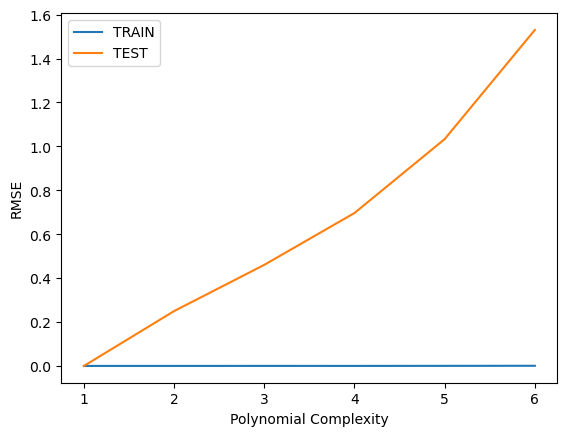

In [63]:
evaluate_stock('Tsla','1mo',7)

6.530026214764436e-12


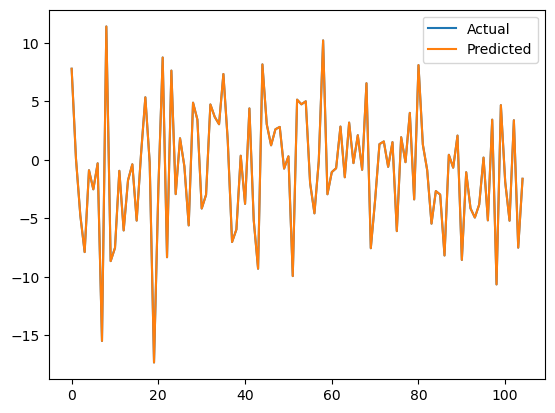

In [64]:
model = create_model('TSLA','2mo',1)
date,X,y= genreate_stock_data('TSLA','5mo')
model_predict(model,1,X,y)

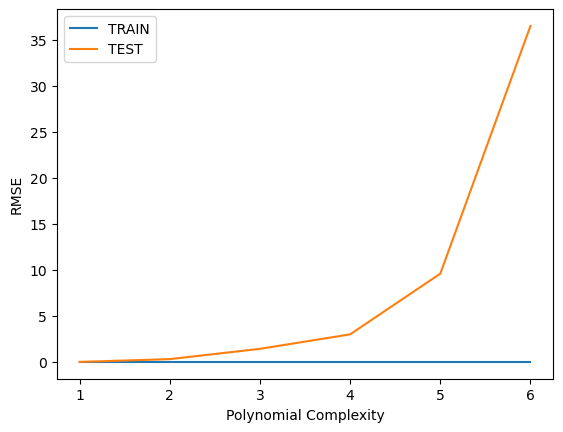

In [65]:
evaluate_stock('ADBE','1mo',7)

1.1099890812855801e-13


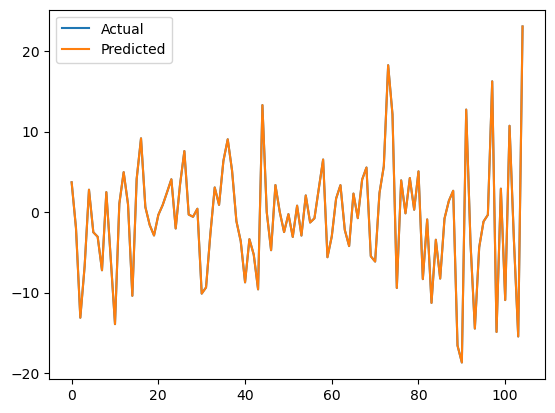

In [66]:
model = create_model('ADBE','2mo',1)
date,X,y= genreate_stock_data('ADBE','5mo')
model_predict(model,1,X,y)